In [1]:
from tdc.single_pred import ADME
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from noiseestimator import NoiseEstimator

In [2]:
dataset = np.linspace(0, 1, 100)
dataset = pd.DataFrame(dataset, columns=['y'])
dataset

,y
0,0.000000
1,0.010101
2,0.020202
3,0.030303
4,0.040404
...,...
95,0.959596
96,0.969697
97,0.979798
98,0.989899


In [4]:
NE = NoiseEstimator(dataset.y, 0.1, noise_type='asymmetric')
NE.noise_bootstraps.describe()

,mae,mse,rmse,r2,pearsonr
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.099618,0.021245,0.145049,0.750111,0.896374
std,0.008896,0.004199,0.014345,0.049394,0.019826
min,0.076027,0.010541,0.102669,0.565252,0.817018
25%,0.093445,0.018398,0.135641,0.718580,0.883687
50%,0.099380,0.020973,0.144822,0.753302,0.898378
75%,0.105542,0.023925,0.154678,0.783591,0.910002
max,0.126748,0.036961,0.192252,0.876013,0.947035


Text(0.5, 0, 'Original')

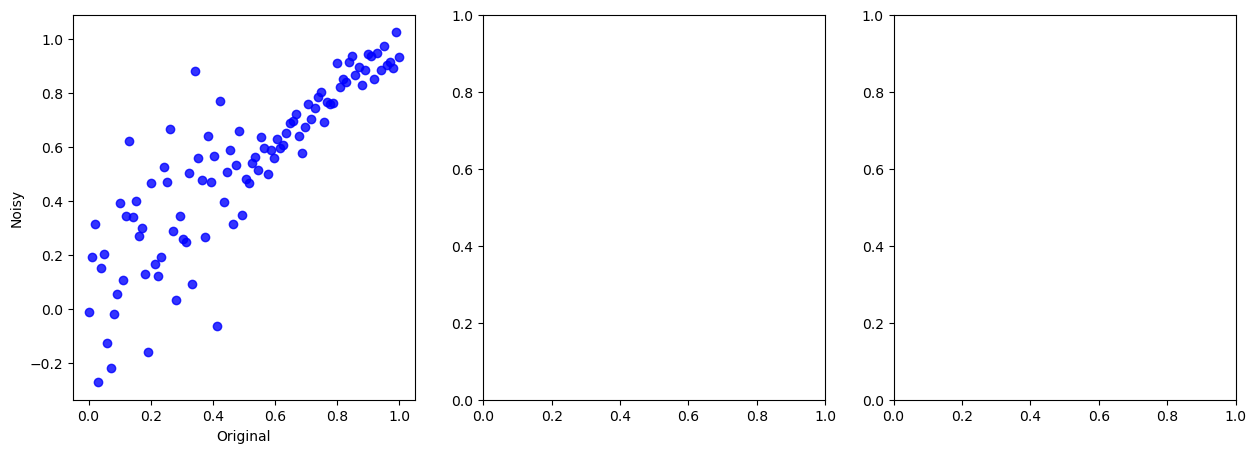

In [5]:
fig = plt.figure(figsize=(15, 5))
axs = [fig.add_subplot(1, 3, 1)]
axs.append(fig.add_subplot(1, 3, 2))
axs.append(fig.add_subplot(1, 3, 3, sharey=axs[1]))
asym_ne = NE.noise_estimates
sns.regplot(asym_ne, x='original', y='noise_0.1', ax=axs[0], fit_reg=False, color='blue', label = 'Gaussian {$\sigma_E$=0.05, $\sigma_E$=0.2}')
axs[0].set_ylabel('Noisy')
axs[0].set_xlabel('Original')

In [6]:
NE_g = NoiseEstimator(dataset.y, 0.1, noise_type='gaussian')
gaussian = NE_g.noise_bootstraps
ne = NE_g.noise_estimates
sns.regplot(ne, x='original', y='noise_0.1', marker='s', ax=axs[0], fit_reg=False, color='red', label='Gaussian $\sigma_E$=0.1')

# now for comparison also Gaussians with 0.05 and 0.2 noise
NE_g_low = NoiseEstimator(dataset.y, 0.05, noise_type='gaussian')
gaussian_low = NE_g_low.noise_bootstraps

NE_g_high = NoiseEstimator(dataset.y, 0.2, noise_type='gaussian')
gaussian_high = NE_g_high.noise_bootstraps

In [7]:
NE_g.noise_bootstraps.describe()

,mae,mse,rmse,r2,pearsonr
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.079892,0.010013,0.099815,0.882228,0.946742
std,0.006099,0.001411,0.007039,0.016597,0.007680
min,0.062498,0.006081,0.077978,0.817954,0.921904
25%,0.075875,0.009039,0.095076,0.871419,0.941782
50%,0.079413,0.009922,0.099609,0.883295,0.947035
75%,0.083698,0.010932,0.104554,0.893675,0.951944
max,0.100010,0.015477,0.124406,0.928477,0.969101


In [8]:
non_uni = NE.noise_bootstraps

# plot overlay of noise levels histogram
sns.histplot(pd.DataFrame(non_uni.pearsonr).melt(), y='value', color='blue', alpha=0.5, label=r'Gaussian {$\sigma_E$=0.05, $\sigma_E$=0.2}', ax=axs[1], orientation='horizontal')
sns.histplot(pd.DataFrame(gaussian.pearsonr).melt(), y='value', color='red', alpha=0.5, label=r'Gaussian $\sigma_E$=0.1', ax=axs[1], orientation='vertical')

sns.kdeplot(pd.DataFrame(gaussian_low.pearsonr).melt(), y='value', color='black', ax=axs[1], linestyle='--', label=r'Gaussian $\sigma_E$=0.05')
sns.kdeplot(pd.DataFrame(gaussian_high.pearsonr).melt(), y='value', color='black', ax=axs[1], linestyle=':', label=r'Gaussian $\sigma_E$=0.2')

axs[1].invert_xaxis()

# vertical line at 0.5
axs[0].axvline(0.5, color='black', linestyle='--', label='Barrier')

axs[0].legend()
axs[1].legend()

axs[0].set_ylabel('Noisy labels y\'')
axs[0].set_xlabel('Original labels y')
axs[1].set_ylabel('Pearson correlation R')
axs[1].set_ylim(0.75, 1.0)

(0.75, 1.0)

In [10]:
# now lets shift the barrier, so that the fraction of low and high noise datapoints is different
barrier = list(np.linspace(0.0,1,11))
print(barrier)

R = []
for b in barrier:
    NE = NoiseEstimator(dataset.y, 0.1, noise_type='asymmetric', asym_bound=b)
    R.append(NE.noise_bootstraps.pearsonr)

[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0]


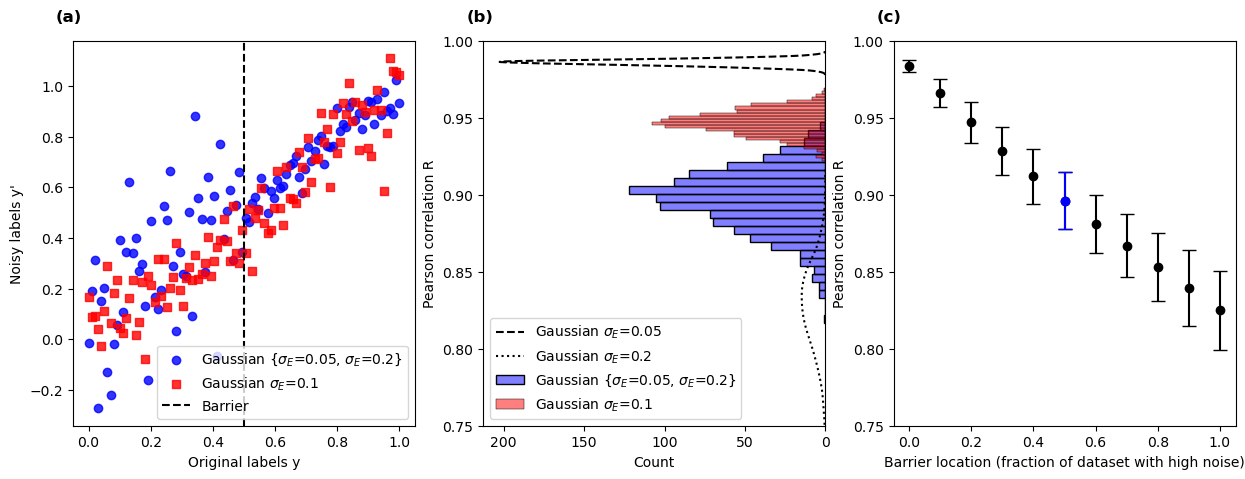

In [12]:
# plot barrier vs average pearson correlation incl error bars
R = np.array(R)
mean = np.mean(R, axis=1)
std = np.std(R, axis=1)
axs[2].errorbar(barrier, mean, yerr=std, fmt='o', color='black', capsize=5)
axs[2].errorbar(0.5, mean[5], yerr=std[5], fmt='o', color='blue', capsize=5)
axs[2].set_xlabel('Barrier location (fraction of dataset with high noise)')
axs[2].set_ylabel('Pearson correlation R')
axs[2].set_ylim(0.75, 1.0)
axs[0].text(-.05, 1.05, '(a)', fontsize=12, transform=axs[0].transAxes, fontweight='bold')
axs[1].text(-.05, 1.05, '(b)', fontsize=12, transform=axs[1].transAxes, fontweight='bold')
axs[2].text(-.05, 1.05, '(c)', fontsize=12, transform=axs[2].transAxes, fontweight='bold')
fig.savefig('../reports/non_uniform_noise.svg')
fig